In [1]:
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
from scipy.signal import correlate
import time

Données du signal_simple:

In [2]:
""" Valeurs"""

l,step = np.linspace(600,1400,1000, retstep = True)
    
l0 = 656.3
z = np.random.uniform(0.0,1.0)
obs = z*l0 + l0
    
dev = 0.01*obs
    
""" DONNEES """

ysig = 20*stats.norm.pdf(l,obs,dev)
bruit = np.random.normal(0,1,1000)
data = ysig + bruit

""" MODELS: Du signal et du bruit """

lmod,step = np.linspace(0,60*step,60, retstep = True)
ymodel = stats.norm.pdf(lmod,(step*60/2),8)

bruitmod = np.random.normal(0,1,1000)
    

Traitement du signal simple par notre code initial:

In [16]:
start = time.time()  


def cross(ymodel,ysig):
        sizemod = np.size(ymodel)
        sizesig = np.size(ysig)
        
        prod = []
    
        for i in range(sizesig-sizemod):
            p = np.dot(ymodel,ysig[i:(i+sizemod)])
            prod.append(p)
        return prod
    

# Corrélations croisées modèle/données
prodat = np.zeros(940)
for i in range(1000):
    prodat += cross(ymodel,data)
prodat /= 1000
# Corrélations croisées modèle/bruit
prodbruit = cross(ymodel,bruitmod)
    
devbr = np.std(prodbruit)
SNR = prodat/devbr


end = time.time()
t = end - start
print(t)

2.777341842651367


Traitement du signal simple par la fonction correlate

In [27]:
start_2 = time.time()

prodat_2 = correlate(data, ymodel, mode='valid')
    
# Corrélations croisées modèle/bruit
prodbruit_2 = correlate(bruitmod, ymodel, mode='valid')
    
devbr_2 = np.std(prodbruit_2)
SNR_2 = prodat_2/devbr_2

end_2 = time.time()
t_2 = end_2 - start_2
print(t_2)

0.0025968551635742188


Text(0.5, 1.0, 'Signal sur bruit')

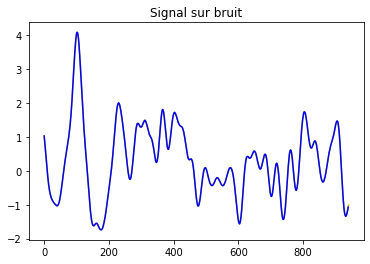

In [29]:
plt.plot(SNR_2, 'y')
plt.plot(SNR, 'b')
plt.title("Signal sur bruit")
# Le signal est tronqué, il faut utilisé le mode valid pour ne pas avoir un décalage



Annalyse signal complexe:

Données initiales nécessaires :

In [6]:
tps = np.linspace(0, 10, 1000, retstep = True)

temps = tps[0]
pas = tps[1]

temps1 = temps[0:100]

pos = np.random.randint(1000-100)

Toutes les fonctions nécessaires regroupées :

In [7]:
def sinusoidal(temps, amplitude_init, pulsation_init):
    
    amplitude = amplitude_init*temps
    pulsation = pulsation_init*temps
    
    signal = amplitude*np.sin(pulsation*temps)
    return signal

def psd(frequence, gamma):
    p = ((frequence[frequence>0])/10)**(gamma) + 1
    return p

def miroir(densite):
    densite = np.insert(densite, 0,  0)
    densite = np.concatenate((densite, np.flip(densite)))
    return densite

def bruit(densite):
    bruit_blanc = np.random.normal(0,1,1000)
    fourier_blanc = np.fft.fft(bruit_blanc)
    
    fourier_color = fourier_blanc*np.sqrt(densite)
    bruit_color = np.real(np.fft.ifft(fourier_color))
    
    return bruit_color

def signalsurbruit(densite, signal, position):
    bruit_color = bruit(densite)
    bruit_color[position:position+np.size(signal)] += signal
    
    return bruit_color

def covariance(densite, temps):
    Cn = np.zeros((100,100))
    for i in range(1000):
        bruit_color = bruit(densite)
        Cn += np.dot(np.transpose(bruit_color[None, 0:100]), bruit_color[None, 0:100])
    Cn /= np.size(temps)
    cov = np.linalg.inv(Cn)
    return cov, Cn

def cross(ymodel,ysig):
        sizemod = np.size(ymodel)
        sizesig = np.size(ysig)
        
        prod = []
    
        for i in range(sizesig-sizemod):
            p = np.dot(ymodel,ysig[i:(i+sizemod)])
            prod.append(p)
        return prod
    
def bruitfiltre(densite,filtre):
    #plt.figure()
    bruit_filtre = np.zeros(900)
    devbr = 0
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        bruit_filtre += prodbruit
        dev = np.std(prodbruit)
        devbr+= dev
    bruit_filtre = bruit_filtre/1000
    devbr = devbr/1000
    return bruit_filtre, devbr

Définition du signal avec le bruit et du modèle du signal et du bruit qu'on va utiliser pour le filtre :

In [31]:
# Signal
amp_init = 2
puls_init = 30 # en rad/s

signal = sinusoidal(temps1, amp_init, puls_init)

#Bruit
gamma = -1.55
frequence = np.fft.fftfreq(np.size(temps), pas)
dens = psd(frequence, gamma)
dens = miroir(dens)

#Bruit + signal (data)
signal_bruit = signalsurbruit(dens, signal, pos)

# Model signal
amp_init_model = 1
signal_model = sinusoidal(temps1, amp_init_model, puls_init)

# Inverse covariance
cov, Cn = covariance(dens, temps)

# Filtre
filtre = np.dot(cov, signal_model)

Correlations croisés et calcul de SNR : 

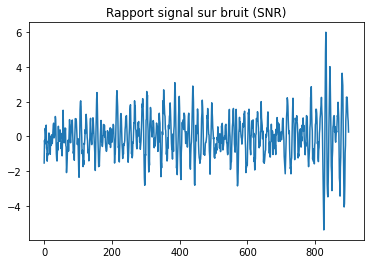

3.3166675567626953


In [32]:
# Signal
start = time.time() 

prodat = cross(filtre, signal_bruit)

#Bruit
bruit_filtre, devbr = bruitfiltre(dens,filtre)

SNR = prodat/devbr

plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

end = time.time()
t = end - start
print(t)

Traitement avec la fonction correlate:

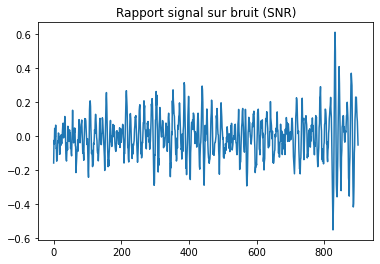

0.34826016426086426


In [33]:
start_2 = time.time()

# Corrélations croisés modèle/signal

prodat_2 = correlate(signal_bruit, filtre, mode='valid')
    
# Corrélations croisées modèle/bruit

prodbruit_2 = correlate(dens, filtre, mode='valid')
    
devbr_2 = np.std(prodbruit_2)
SNR_2 = prodat_2/devbr_2

plt.plot(SNR_2)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

end_2 = time.time()
t_2 = end_2 - start_2
print(t_2)

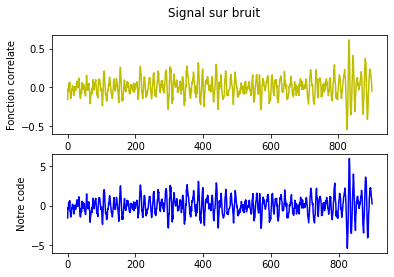

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Signal sur bruit')

ax1.plot(SNR_2, 'y')
ax1.set_ylabel('Fonction correlate')

ax2.plot(SNR, 'b')
ax2.set_ylabel('Notre code')

plt.show()

A ne pas exécuter tout de suite ça prend du temps on le fera à la fin:
(entourer la fonction voulue avec start/stop)

In [ ]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

tracker.stop()